Train uni with switching then test on multi
How does network change during switch periods.

# Import

In [1]:
from lstm_net import *
import torch.nn as nn
import Tmaze_UniToMulti as TMUM
import plotting_functions as pf
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

importlib.reload(pf)

# Check CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


## Helper Function to get tensors on same device

In [2]:
def ensure_same_device(model, *tensors):
    """Moves all tensors to the same device as the model."""
    device = next(model.parameters()).device
    return [t.to(device) for t in tensors]

def print_device_info(*tensors, model=None):
    """Prints device information for debugging."""
    if model:
        print(f"Model device: {next(model.parameters()).device}")
    for i, t in enumerate(tensors):
        print(f"Tensor {i} device: {t.device}")



## Train Model on Unisensory

In [ ]:
# Set device and print for verification
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


# Generate trials
u, z, mask, conditions_train = TMUM.TmazeEnv2.generate_trials(
    n_trials=10000,
    alpha=0.2,
    sigma_in=0.01,
    baseline=0.2,
    n_coh=15,
    trials_per_context=50,
    modality='uni'  # or 'multi' for testing
)

# Convert numpy arrays to tensors and move to GPU
u = torch.tensor(u, dtype=torch.float32).to(device)
z = torch.tensor(z, dtype=torch.float32).to(device)
mask = torch.tensor(mask, dtype=torch.float32).to(device)

# Create and move model to GPU
input_size = u.shape[2]  # Should be 4 (2 visual, 2 audio inputs)
net = Net_lstm(n=50, input_size=input_size, dale=True, sigma_rec=0.15)
net = net.to(device)

# Verify device placement
print(f"Model device: {next(net.parameters()).device}")
print(f"Input tensor device: {u.device}")
print(f"Target tensor device: {z.device}")
print(f"Mask tensor device: {mask.device}")

# Train the network
net.fit(u, z, mask, 
        lr=0.0001,  # Learning rate for unimodal training
        epochs=300, 
        verbose=True, 
        weight_decay=0.001)

# Print metrics
print(f"\nInput tensor shape: {u.shape}")
print(f"Target tensor shape: {z.shape}")
print(f"Mask tensor shape: {mask.shape}")

# Count trials by context
visual_count = sum(1 for condition in conditions_train if condition['context'] == 'visual')
audio_count = sum(1 for condition in conditions_train if condition['context'] == 'audio')

print(f"\nVisual trials: {visual_count}")
print(f"Audio trials: {audio_count}")


Using device: cuda


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_19676\455857728.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, dtype=torch.float32).to(device)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_19676\455857728.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32).to(device)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_19676\455857728.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).to(device)


Model device: cuda:0
Input tensor device: cuda:0
Target tensor device: cuda:0
Mask tensor device: cuda:0


c:\Users\Runyan1\AppData\Local\anaconda3\envs\RNN\Lib\site-packages\torch\nn\modules\rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1412.)
  result = _VF.lstm(


Epoch: 5/300............. mse_z: 0.0653
Epoch: 10/300............. mse_z: 0.0562
Epoch: 15/300............. mse_z: 0.0126
Epoch: 20/300............. mse_z: 0.0080
Epoch: 25/300............. mse_z: 0.0062
Epoch: 30/300............. mse_z: 0.0052
Epoch: 35/300............. mse_z: 0.0047
Epoch: 40/300............. mse_z: 0.0045
Epoch: 45/300............. mse_z: 0.0040
Epoch: 50/300............. mse_z: 0.0042
Epoch: 55/300............. mse_z: 0.0042
Epoch: 60/300............. mse_z: 0.0044
Epoch: 65/300............. mse_z: 0.0038
Epoch: 70/300............. mse_z: 0.0037
Epoch: 75/300............. mse_z: 0.0037
Epoch: 80/300............. mse_z: 0.0038
Epoch: 85/300............. mse_z: 0.0040
Epoch: 90/300............. mse_z: 0.0038
Epoch: 95/300............. mse_z: 0.0042
Epoch: 100/300............. mse_z: 0.0036
Epoch: 105/300............. mse_z: 0.0035
Epoch: 110/300............. mse_z: 0.0040
Epoch: 115/300............. mse_z: 0.0035
Epoch: 120/300............. mse_z: 0.0036
Epoch: 125/3

## Save Model

In [5]:
import torch

# Save the trained model and its parameters
MODEL_PATH = 'trained_uni_85_15_.2_V2.pth'
torch.save({
    'model_state_dict': net.state_dict(),
    'hidden_size': net.n,
    'input_size': net.input_size,
    'output_size': 2,
    'alpha': net.alpha,
    'sigma_rec': net.sigma_rec,
    'device': str(net.device),
    'conditions': conditions_train,
}, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

NameError: name 'conditions_train' is not defined

## Load Model

## Model paths

1. trained_uni_model.pth - base/random initialization, 0 input for non relevant modality
2. trained_uni_60_40_0.pth - 60% excite, 40% inhibi, 0 input for non relevant modality
3. trained_uni_.2.pth - random initialization, .2 input for non relevant modality
4. trained_uni_85_15_0 - 85% excite, 15% inhib, cortex ratio of e/i
5. trained_uni_85_15_.2 - 85/15 ratio, .2 input for non relevant context


In [22]:
from lstm_net import Net_lstm
import torch


# Load the saved parameters
MODEL_PATH = 'trained_uni_85_15_0.pth'
checkpoint = torch.load(MODEL_PATH, weights_only=False)

# Initialize the network with saved parameters
net = Net_lstm(
    n=checkpoint['hidden_size'],
    input_size=checkpoint['input_size'],
    output_size=checkpoint['output_size'],
    alpha=checkpoint['alpha'],
    sigma_rec=checkpoint['sigma_rec']
)

# Load the trained weights
net.load_state_dict(checkpoint['model_state_dict'])
conditions = checkpoint['conditions']  # Load conditions from training session
net.to(checkpoint['device'])
net.eval()  # Set to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


c:\Users\Runyan1\Downloads\RNN\lstm_net.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha = torch.tensor(alpha)
c:\Users\Runyan1\Downloads\RNN\lstm_net.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_rec = torch.tensor(sigma_rec)


## Test on unisensory

Model moved to: cuda:0

Pre-inference Device Verification:
Model device: cuda:0
Tensor 0 device: cuda:0
Tensor 1 device: cuda:0
Tensor 2 device: cuda:0

Post-inference Device Verification:

Unisensory Test Accuracy: 99.70%


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\1132652320.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_test = torch.tensor(u_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\1132652320.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_test = torch.tensor(z_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\1132652320.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test, dtype=torch.float32)


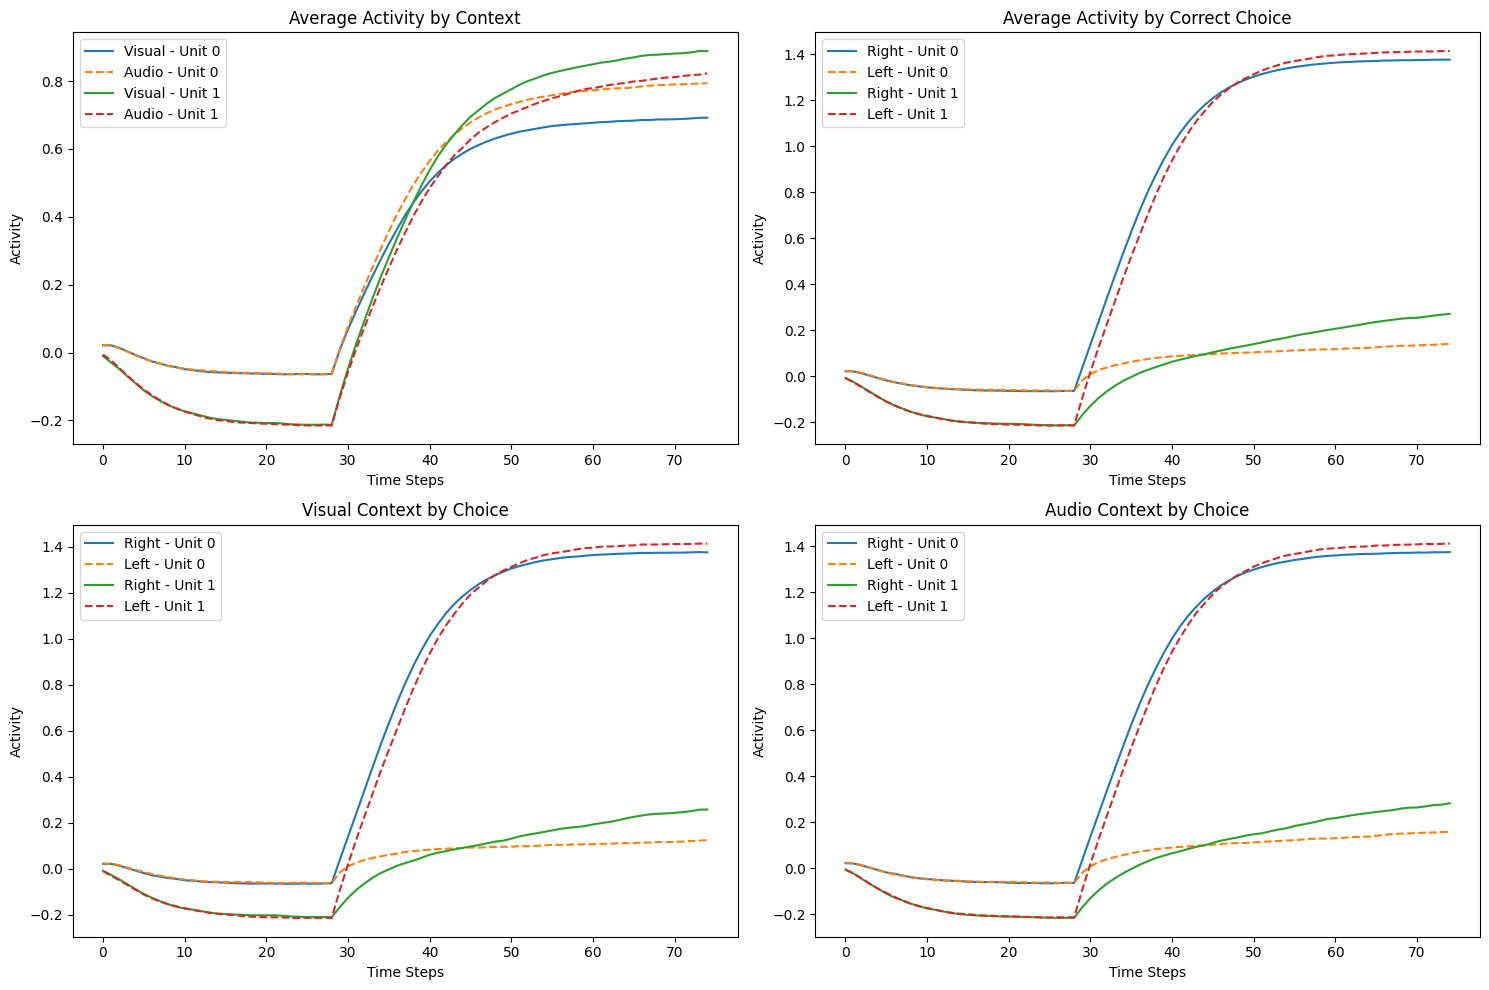

In [23]:
# First, explicitly move model to desired device (CPU in this case)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.eval()
print(f"Model moved to: {next(net.parameters()).device}")

# Generate and evaluate test trials
with torch.no_grad():
    u_test, z_test, mask_test, conditions = TMUM.TmazeEnv2.generate_trials(
        n_trials=1000,
        alpha=0.2,
        sigma_in=0.01,
        baseline=0.2,
        n_coh=15,
        trials_per_context=50,
        modality='uni'
    )
    
    # Convert to tensors and ensure they're on same device as model
    u_test = torch.tensor(u_test, dtype=torch.float32)
    z_test = torch.tensor(z_test, dtype=torch.float32)
    mask_test = torch.tensor(mask_test, dtype=torch.float32)
    
    # Move all tensors to model's device
    u_test, z_test, mask_test = ensure_same_device(net, u_test, z_test, mask_test)
    
    # Verify device placement
    print("\nPre-inference Device Verification:")
    print_device_info(u_test, z_test, mask_test, model=net)
    
    # Get network predictions
    with torch.no_grad():
        outputs, hidden = net(u_test)
    
    # Verify output devices
    print("\nPost-inference Device Verification:")
    
    # Get decisions from final timestep (ensure on same device)
    decisions = outputs[:, -1, :]
    correct_choices = torch.tensor([1 if c['correct_choice'] == 1 else 0 
                                  for c in conditions], 
                                 device=decisions.device)  # Create on same device
    
    predictions = (torch.relu(decisions[:, 0] - decisions[:, 1]) > 0).float()
    accuracy = (predictions == correct_choices).float().mean()
    
    print(f"\nUnisensory Test Accuracy: {accuracy.item():.2%}")
    
    # Move outputs to CPU for plotting if needed
    outputs_cpu = outputs.cpu()
    fig = pf.plot_network_activity_analysis(conditions, outputs_cpu)
    plt.show()

## Test on Multisensory

Model moved to: cuda:0

Pre-inference Device Verification:
Model device: cuda:0
Tensor 0 device: cuda:0
Tensor 1 device: cuda:0
Tensor 2 device: cuda:0

Post-inference Device Verification:

Multisensory Test Accuracy: 75.70%


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\4020245257.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_test = torch.tensor(u_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\4020245257.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_test = torch.tensor(z_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\4020245257.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test, dtype=torch.float32)


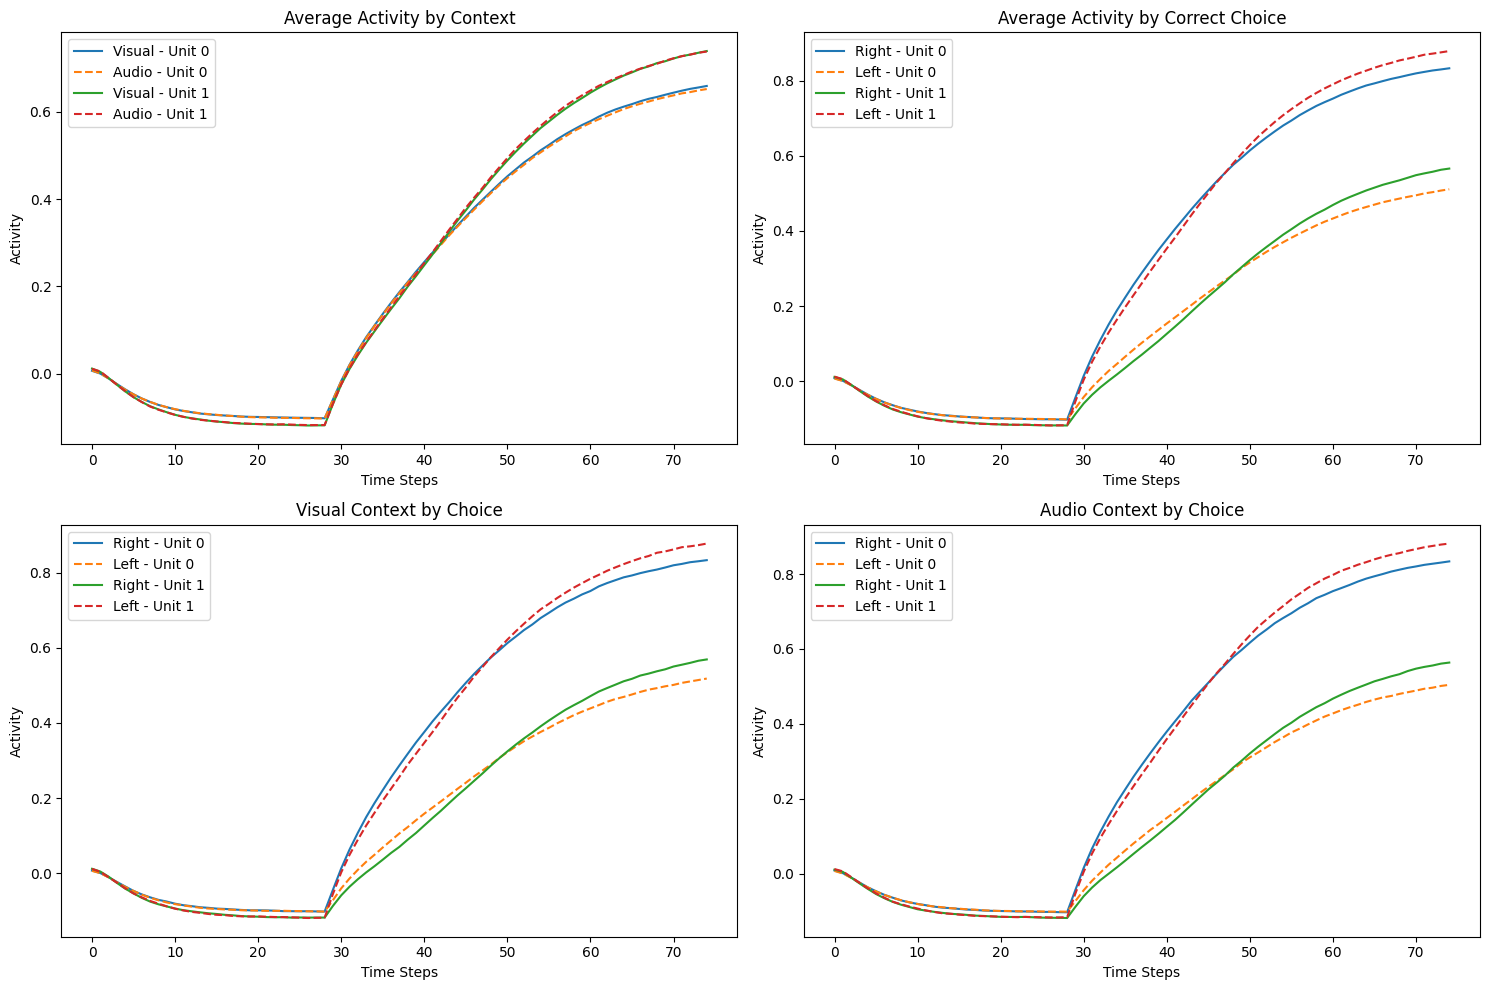

In [35]:
# First, explicitly move model to desired device (CPU in this case)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.eval()
print(f"Model moved to: {next(net.parameters()).device}")

# Generate and evaluate test trials
with torch.no_grad():
    u_test, z_test, mask_test, conditions_test = TMUM.TmazeEnv2.generate_trials(
        n_trials=1000,
        alpha=0.2,
        sigma_in=0.01,
        baseline=0.2,
        n_coh=15,
        trials_per_context=50,
        modality='multi'
    )
    
    # Convert to tensors and ensure they're on same device as model
    u_test = torch.tensor(u_test, dtype=torch.float32)
    z_test = torch.tensor(z_test, dtype=torch.float32)
    mask_test = torch.tensor(mask_test, dtype=torch.float32)
    
    # Move all tensors to model's device
    u_test, z_test, mask_test = ensure_same_device(net, u_test, z_test, mask_test)
    
    # Verify device placement
    print("\nPre-inference Device Verification:")
    print_device_info(u_test, z_test, mask_test, model=net)
    
    # Get network predictions
    with torch.no_grad():
        outputs, hidden = net(u_test)
    
    # Verify output devices
    print("\nPost-inference Device Verification:")
    
    # Get decisions from final timestep (ensure on same device)
    decisions_test = outputs[:, -1, :]
    correct_choices_test = torch.tensor([1 if c['correct_choice'] == 1 else 0 
                                  for c in conditions_test], 
                                 device=decisions_test.device)  # Create on same device
    
    predictions_test = (torch.relu(decisions_test[:, 0] - decisions_test[:, 1]) > 0).float()
    accuracy_test = (predictions_test == correct_choices_test).float().mean()
    
    print(f"\nMultisensory Test Accuracy: {accuracy_test.item():.2%}")
    
    # Move outputs to CPU for plotting if needed
    outputs_cpu = outputs.cpu()
    fig = pf.plot_network_activity_analysis(conditions_test, outputs_cpu)
    plt.show()

## Visualize Network Weights

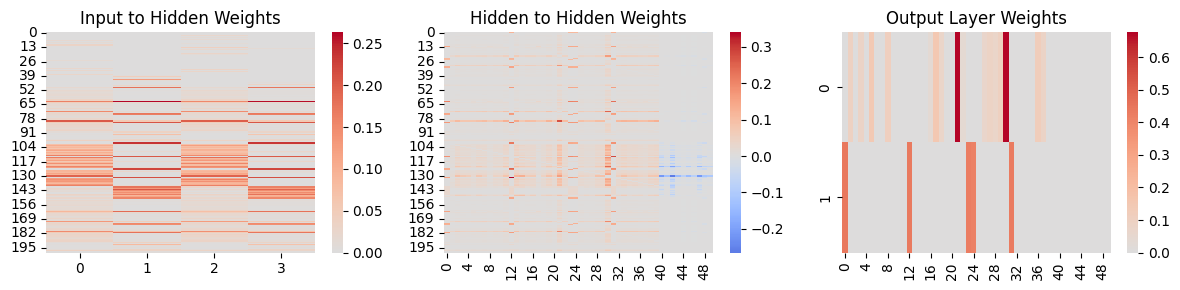

In [27]:
# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Input to Hidden weights
weights_ih = net.lstm.weight_ih_l0.data.cpu().detach().numpy()
sns.heatmap(weights_ih, center=0, cmap="coolwarm", ax=axes[0])
axes[0].set_title('Input to Hidden Weights')

# Hidden to Hidden weights
weights_hh = net.lstm.weight_hh_l0.data.cpu().detach().numpy()
sns.heatmap(weights_hh, center=0, cmap="coolwarm", ax=axes[1])
axes[1].set_title('Hidden to Hidden Weights')

# Output weights
output_weights = net.output_layer.weight.data.cpu().detach().numpy()
sns.heatmap(output_weights, center=0, cmap="coolwarm", ax=axes[2])
axes[2].set_title('Output Layer Weights')

# Adjust layout to prevent overlap
plt.tight_layout()

# Optional: Save the figure
plt.savefig('weight_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## Network Pyschometric on Multisensory

Why are we so biased?

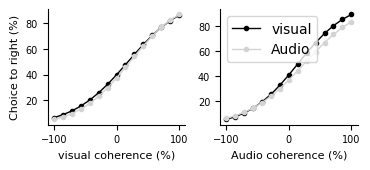

In [28]:
importlib.reload(pf)

df = pf.psychometric(net, u_test, conditions_test)

# Train Multi Test Uni

In [29]:
importlib.reload(TMUM)

# Set device and print for verification
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


# Generate trials
u, z, mask, conditions_train = TMUM.TmazeEnv2.generate_trials(
    n_trials=10000,
    alpha=0.2,
    sigma_in=0.01,
    baseline=0.2,
    n_coh=15,
    trials_per_context=50,
    modality='multi'
)

# Convert numpy arrays to tensors and move to GPU
u = torch.tensor(u, dtype=torch.float32).to(device)
z = torch.tensor(z, dtype=torch.float32).to(device)
mask = torch.tensor(mask, dtype=torch.float32).to(device)

# Create and move model to GPU
input_size = u.shape[2]  # Should be 4 (2 visual, 2 audio inputs)
net = Net_lstm(n=50, input_size=input_size, dale=True, sigma_rec=0.15)
net = net.to(device)

# Verify device placement
print(f"Model device: {next(net.parameters()).device}")
print(f"Input tensor device: {u.device}")
print(f"Target tensor device: {z.device}")
print(f"Mask tensor device: {mask.device}")

# Train the network
net.fit(u, z, mask, 
        lr=0.0001,  # Learning rate for unimodal training
        epochs=300, 
        verbose=True, 
        weight_decay=0.001)

# Print metrics
print(f"\nInput tensor shape: {u.shape}")
print(f"Target tensor shape: {z.shape}")
print(f"Mask tensor shape: {mask.shape}")

# Count trials by context
visual_count = sum(1 for condition in conditions_train if condition['context'] == 'visual')
audio_count = sum(1 for condition in conditions_train if condition['context'] == 'audio')

print(f"\nVisual trials: {visual_count}")
print(f"Audio trials: {audio_count}")


Using device: cuda


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\1245609103.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, dtype=torch.float32).to(device)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\1245609103.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32).to(device)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\1245609103.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).to(device)


Model device: cuda:0
Input tensor device: cuda:0
Target tensor device: cuda:0
Mask tensor device: cuda:0


c:\Users\Runyan1\AppData\Local\anaconda3\envs\RNN\Lib\site-packages\torch\nn\modules\rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1412.)
  result = _VF.lstm(


Epoch: 5/300............. mse_z: 0.0655
Epoch: 10/300............. mse_z: 0.0605
Epoch: 15/300............. mse_z: 0.0476
Epoch: 20/300............. mse_z: 0.0428
Epoch: 25/300............. mse_z: 0.0426
Epoch: 30/300............. mse_z: 0.0427
Epoch: 35/300............. mse_z: 0.0427
Epoch: 40/300............. mse_z: 0.0428
Epoch: 45/300............. mse_z: 0.0427
Epoch: 50/300............. mse_z: 0.0426
Epoch: 55/300............. mse_z: 0.0424
Epoch: 60/300............. mse_z: 0.0424
Epoch: 65/300............. mse_z: 0.0423
Epoch: 70/300............. mse_z: 0.0422
Epoch: 75/300............. mse_z: 0.0423
Epoch: 80/300............. mse_z: 0.0423
Epoch: 85/300............. mse_z: 0.0424
Epoch: 90/300............. mse_z: 0.0422
Epoch: 95/300............. mse_z: 0.0423
Epoch: 100/300............. mse_z: 0.0421
Epoch: 105/300............. mse_z: 0.0422
Epoch: 110/300............. mse_z: 0.0422
Epoch: 115/300............. mse_z: 0.0421
Epoch: 120/300............. mse_z: 0.0420
Epoch: 125/3

## Save Model

In [30]:
import torch

# Save the trained model and its parameters
MODEL_PATH = 'trained_multi_85_15_0.pth'
torch.save({
    'model_state_dict': net.state_dict(),
    'hidden_size': net.n,
    'input_size': net.input_size,
    'output_size': 2,
    'alpha': net.alpha,
    'sigma_rec': net.sigma_rec,
    'device': str(net.device),
    'conditions': conditions_train,
}, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to trained_multi_85_15_0.pth


## Load Model

### Model Paths

1. trained_multi_dale_85_15_0.pth - dale's law, 85/15 E/I ratio, 0 irrelevant input on uni, now testing epoch
2. trained_multi_dale_85_15_2.pth - dale's, 85/15, .2 irrelevant stim on uni testing

In [31]:
from lstm_net import Net_lstm
import torch


# Load the saved parameters
MODEL_PATH = 'trained_multi_85_15_0.pth'
checkpoint = torch.load(MODEL_PATH, weights_only=False)

# Initialize the network with saved parameters
net = Net_lstm(
    n=checkpoint['hidden_size'],
    input_size=checkpoint['input_size'],
    output_size=checkpoint['output_size'],
    alpha=checkpoint['alpha'],
    sigma_rec=checkpoint['sigma_rec']
)

# Load the trained weights
net.load_state_dict(checkpoint['model_state_dict'])
conditions = checkpoint['conditions']  # Load conditions from training session
net.to(checkpoint['device'])
net.eval()  # Set to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


c:\Users\Runyan1\Downloads\RNN\lstm_net.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha = torch.tensor(alpha)
c:\Users\Runyan1\Downloads\RNN\lstm_net.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_rec = torch.tensor(sigma_rec)


## Test on Multi

Model moved to: cuda:0

Pre-inference Device Verification:
Model device: cuda:0
Tensor 0 device: cuda:0
Tensor 1 device: cuda:0
Tensor 2 device: cuda:0

Post-inference Device Verification:


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\3721844830.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_test = torch.tensor(u_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\3721844830.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_test = torch.tensor(z_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\3721844830.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test, dtype=torch.float32)



Multisensory Test Accuracy: 75.70%


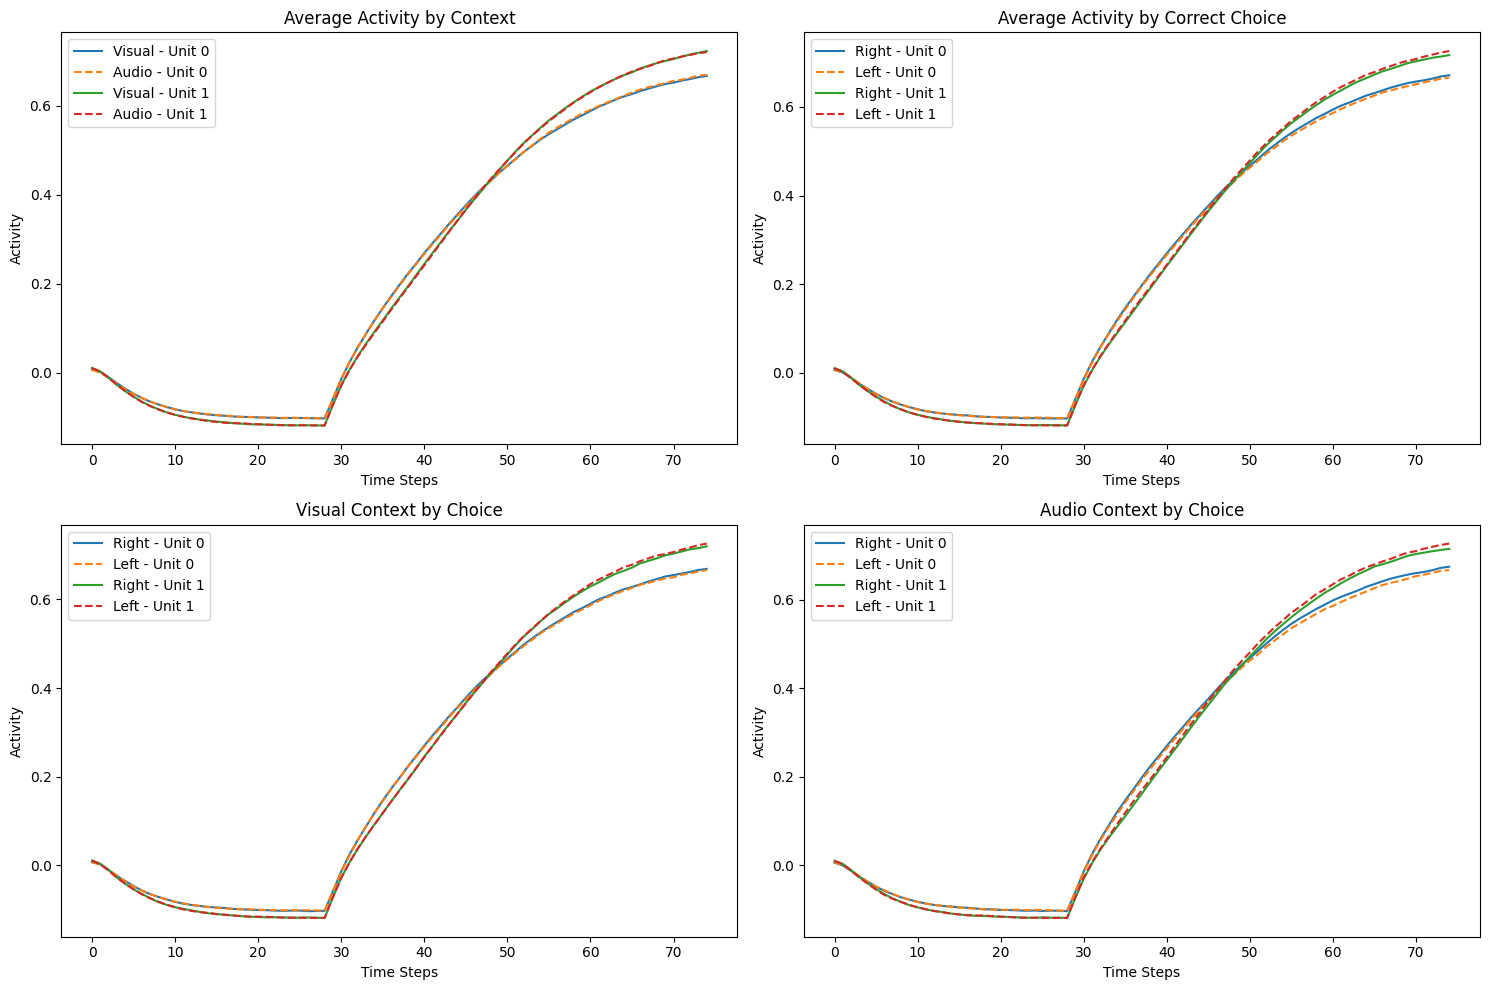

In [36]:
# First, explicitly move model to desired device (CPU in this case)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.eval()
print(f"Model moved to: {next(net.parameters()).device}")

# Generate and evaluate test trials
with torch.no_grad():
    u_test, z_test, mask_test, conditions_multi_test = TMUM.TmazeEnv2.generate_trials(
        n_trials=1000,
        alpha=0.2,
        sigma_in=0.01,
        baseline=0.2,
        n_coh=15,
        trials_per_context=50,
        modality='multi'
    )
    
    # Convert to tensors and ensure they're on same device as model
    u_test = torch.tensor(u_test, dtype=torch.float32)
    z_test = torch.tensor(z_test, dtype=torch.float32)
    mask_test = torch.tensor(mask_test, dtype=torch.float32)
    
    # Move all tensors to model's device
    u_test, z_test, mask_test = ensure_same_device(net, u_test, z_test, mask_test)
    
    # Verify device placement
    print("\nPre-inference Device Verification:")
    print_device_info(u_test, z_test, mask_test, model=net)
    
    # Get network predictions
    with torch.no_grad():
        outputs, hidden = net(u_test)
    
    # Verify output devices
    print("\nPost-inference Device Verification:")
    
    # Get decisions from final timestep (ensure on same device)
    decisions_multi_test = outputs[:, -1, :]
    correct_choices_multi_test = torch.tensor([1 if c['correct_choice'] == 1 else 0 
                                  for c in conditions_multi_test], 
                                 device=decisions_multi_test.device)  # Create on same device
    
    predictions_multi_test = (torch.relu(decisions_multi_test[:, 0] - decisions_multi_test[:, 1]) > 0).float()
    accuracy_multi_test = (predictions_multi_test == correct_choices_multi_test).float().mean()
    
    print(f"\nMultisensory Test Accuracy: {accuracy_test.item():.2%}")
    
    # Move outputs to CPU for plotting if needed
    outputs_cpu = outputs.cpu()
    fig = pf.plot_network_activity_analysis(conditions_test, outputs_cpu)
    plt.show()

## Test on Uni

Model moved to: cuda:0

Pre-inference Device Verification:
Model device: cuda:0
Tensor 0 device: cuda:0
Tensor 1 device: cuda:0
Tensor 2 device: cuda:0

Post-inference Device Verification:


C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\928242639.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_test = torch.tensor(u_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\928242639.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_test = torch.tensor(z_test, dtype=torch.float32)
C:\Users\Runyan1\AppData\Local\Temp\ipykernel_17328\928242639.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_test = torch.tensor(mask_test, dtype=torch.float32)



Unisensory Test Accuracy: 94.50%


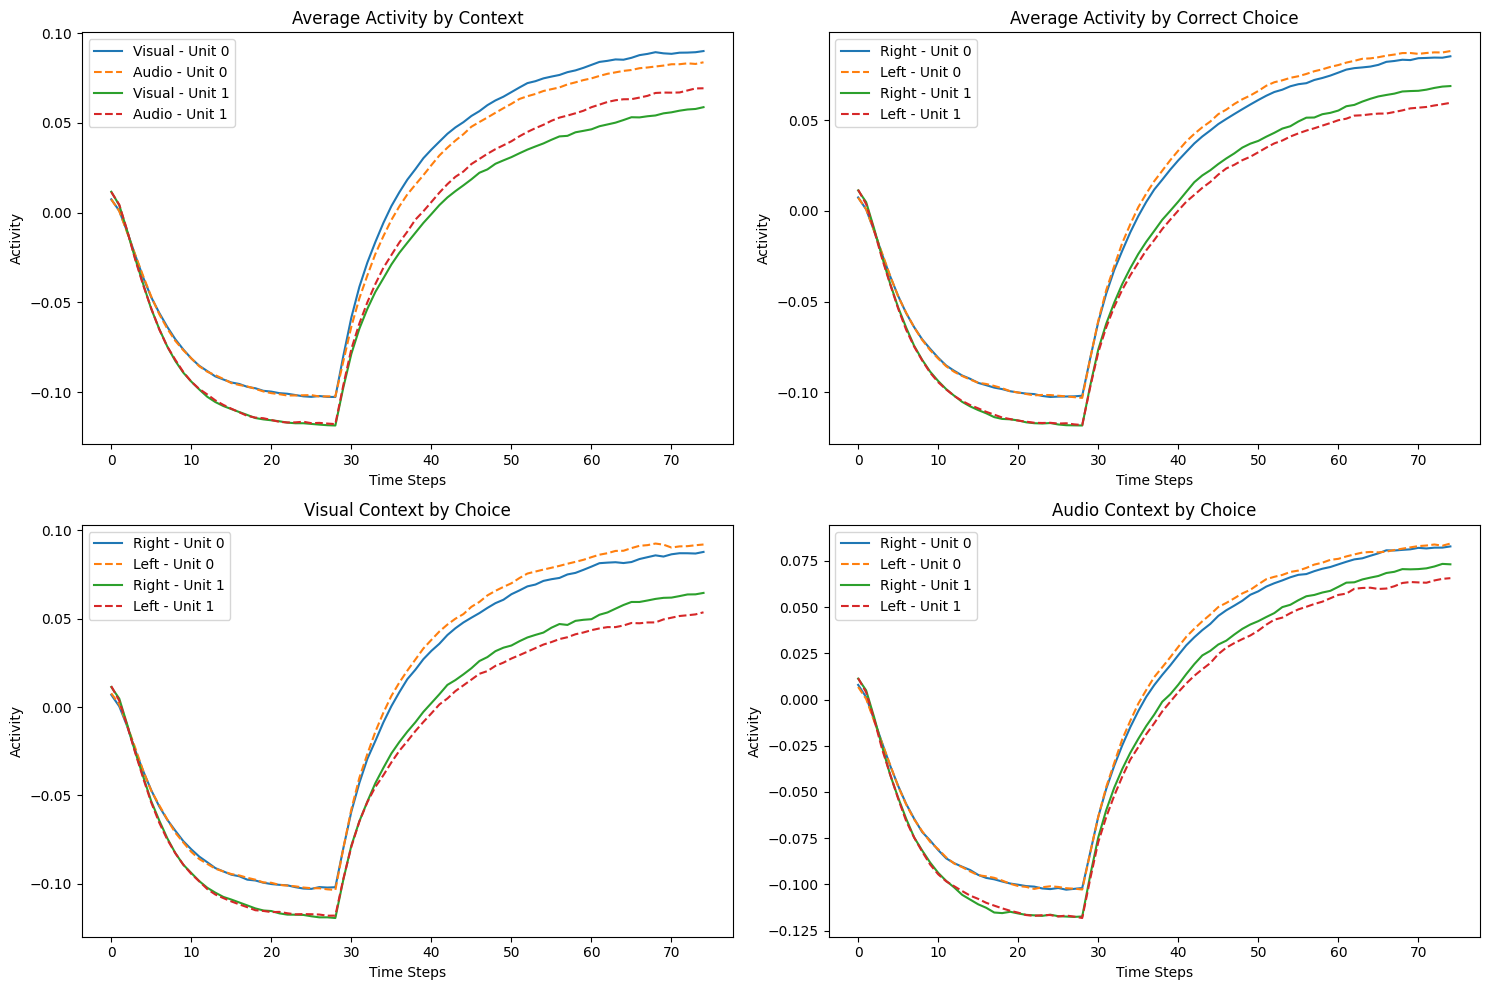

In [37]:
# First, explicitly move model to desired device (CPU in this case)
net = net.cuda() if torch.cuda.is_available() else net.cpu()
net.eval()
print(f"Model moved to: {next(net.parameters()).device}")

# Generate and evaluate test trials
with torch.no_grad():
    u_test, z_test, mask_test, conditions_uni_test = TMUM.TmazeEnv2.generate_trials(
        n_trials=1000,
        alpha=0.2,
        sigma_in=0.01,
        baseline=0.2,
        n_coh=15,
        trials_per_context=50,
        modality='uni'
    )
    
    # Convert to tensors and ensure they're on same device as model
    u_test = torch.tensor(u_test, dtype=torch.float32)
    z_test = torch.tensor(z_test, dtype=torch.float32)
    mask_test = torch.tensor(mask_test, dtype=torch.float32)
    
    # Move all tensors to model's device
    u_test, z_test, mask_test = ensure_same_device(net, u_test, z_test, mask_test)
    
    # Verify device placement
    print("\nPre-inference Device Verification:")
    print_device_info(u_test, z_test, mask_test, model=net)
    
    # Get network predictions
    with torch.no_grad():
        outputs, hidden = net(u_test)
    
    # Verify output devices
    print("\nPost-inference Device Verification:")
    
    # Get decisions from final timestep (ensure on same device)
    decisions_uni_test = outputs[:, -1, :]
    correct_choices_uni_test = torch.tensor([1 if c['correct_choice'] == 1 else 0 
                                  for c in conditions_uni_test], 
                                 device=decisions_uni_test.device)  # Create on same device
    
    predictions_uni_test = (torch.relu(decisions_uni_test[:, 0] - decisions_uni_test[:, 1]) > 0).float()
    accuracy_uni_test = (predictions_uni_test == correct_choices_uni_test).float().mean()
    
    print(f"\nUnisensory Test Accuracy: {accuracy.item():.2%}")
    
    # Move outputs to CPU for plotting if needed
    outputs_cpu = outputs.cpu()
    fig = pf.plot_network_activity_analysis(conditions, outputs_cpu)
    plt.show()

# Unit Selectivity